# [**Workflows for atomistic simulations**](http://potentials.rub.de/) 

## **Day 3 - Validation of various potentials**


### **Exercise 1: Validation of generated potentials using pyiron based workflows**

Before the excercise, you should:

* Have run the notebooks from day 1 and day2
* Be familiar with working with pyiron and the basics of potential fitting

The aim of this exercise is to make you familiar with:

* Potential validation techniques

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd

In [2]:
from pyiron import Project

In [3]:
pr = Project("validation")

In [4]:
pot_finder = pr.inspect_emperical_potentials()
pot_list = pot_finder.find("Cu")
pot_list

,Config,Filename,Model,Name,Species,Citations
0,"[pair_style pace\n, pair_coeff * * df3_cut75_l...",[ace/df3_cut75_large_body_order.ace],ACE,Cu-ace,[Cu],{}
0,"[pair_style nnp dir ""."" showew no showewsum 0 ...","[runner/input.nn, runner/weights.029.data, run...",RuNNer,Cu-runner,[Cu],{}


In [5]:
# The list of potentials to iterate over

# The good potentials
potential_list = ['Cu-ace', 'Cu-runner']

In [6]:
# Do Murnaghan, ElasticMatrix job, vac formation energy, binding energy, surface energies, comparison with dataset forces, energies

In [7]:
def clean_project_name(name):
    return name.replace("-", "_")

2021-03-08 09:55:42,874 - pyiron_log - WARNING - The job murn_job is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


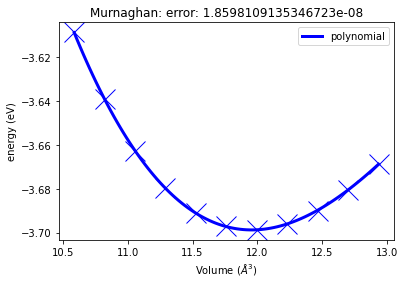

2021-03-08 09:55:45,597 - pyiron_log - WARNING - The job murn_job is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


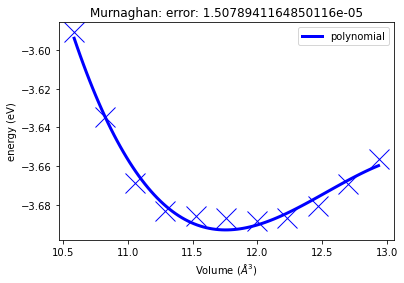

CPU times: user 4.19 s, sys: 1.69 s, total: 5.88 s
Wall time: 5.25 s


In [8]:
%%time
for pot in potential_list:
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(pot)
    job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, "ref_job")
    job_ref.structure = pr_pot.create_ase_bulk("Cu")
    job_ref.potential = pot
    job_ref.calc_minimize()
    murn_job = job_ref.create_job(pr_pot.job_type.Murnaghan, "murn_job")
    murn_job.run()
    murn_job.plot()

In [9]:
murn_job["output/equilibrium_energy"]

-3.6930468810926627

In [10]:
def get_only_murn(job_table):
    return job_table.hamilton == "Murnaghan"

def get_eq_vol(job_path):
    return job_path["output/equilibrium_volume"]

def get_eq_lp(job_path):
    return np.linalg.norm(job_path["output/structure/cell/cell"][0]) * np.sqrt(2)

def get_eq_bm(job_path):
    return job_path["output/equilibrium_bulk_modulus"]

def get_potential(job_path):
    return job_path["ref_job/input/potential/Name"]

def get_eq_energy(job_path):
    return job_path["output/equilibrium_energy"]

def get_n_atoms(job_path):
    return len(job_path["output/structure/positions"])

In [11]:
%%time
table = pr.create_table("table_murn", delete_existing_job=True)
table.db_filter_function = get_only_murn
table.add["potential"] = get_potential
table.add["a"] = get_eq_lp
table.add["eq_vol"] = get_eq_vol
table.add["eq_bm"] = get_eq_bm
table.add["eq_energy"] = get_eq_energy
table.add["n_atoms"] = get_n_atoms
table.run()
data_murn = table.get_dataframe()
data_murn

100%|██████████| 2/2 [00:00<00:00, 16.70it/s]

The job table_murn was saved and received the ID: 25


CPU times: user 297 ms, sys: 125 ms, total: 422 ms
Wall time: 432 ms


,job_id,potential,a,eq_vol,eq_bm,eq_energy,n_atoms
0,1,Cu-ace,3.629863,11.956678,146.220099,-3.698781,1
1,13,Cu-runner,3.609436,11.755954,181.669418,-3.693047,1


In [12]:
import pyiron_gpl

In [20]:
%%time
for pot in data_murn.potential.to_list():
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(pot)
    job_id = int(data_murn[data_murn.potential==pot].job_id)
    job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, "ref_job")
    job_ref.structure = pr_pot.inspect(job_id)["output/structure"].to_object()
    job_ref.potential = pot
    job_ref.calc_minimize()
    elastic_job = job_ref.create_job(pr_pot.job_type.ElasticMatrixJob, "elastic_job")
    elastic_job.input["eps_range"] = 0.05
    elastic_job.run()

The job elastic_job was saved and received the ID: 55
The job s_e_0 was saved and received the ID: 56
The job s_01_e_m0_05000 was saved and received the ID: 57
The job s_01_e_m0_02500 was saved and received the ID: 58
The job s_01_e_0_02500 was saved and received the ID: 59
The job s_01_e_0_05000 was saved and received the ID: 60
The job s_08_e_m0_05000 was saved and received the ID: 61
The job s_08_e_m0_02500 was saved and received the ID: 62
The job s_08_e_0_02500 was saved and received the ID: 63
The job s_08_e_0_05000 was saved and received the ID: 64
The job s_23_e_m0_05000 was saved and received the ID: 65
The job s_23_e_m0_02500 was saved and received the ID: 66
The job s_23_e_0_02500 was saved and received the ID: 67
The job s_23_e_0_05000 was saved and received the ID: 68
The job elastic_job was saved and received the ID: 69
The job s_e_0 was saved and received the ID: 70
The job s_01_e_m0_05000 was saved and received the ID: 71
The job s_01_e_m0_02500 was saved and received t

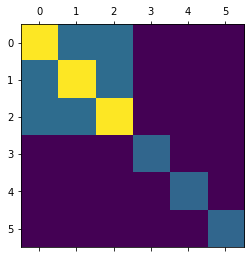

In [21]:
plt.matshow(elastic_job["output/elasticmatrix"]["C"]);

In [15]:
elastic_job["output/elasticmatrix"]["C"].flatten()

array([-33.986037  , -23.19032409, -23.19032409,   0.        ,
         0.        ,   0.        , -23.19032409, -33.986037  ,
       -23.19032409,   0.        ,   0.        ,   0.        ,
       -23.19032409, -23.19032409, -33.986037  ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  82.38732055,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        82.38732055,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  82.38732055])

In [24]:
def filter_elastic(job_table):
    return (job_table.hamilton == "ElasticMatrixJob") & (job_table.status == "finished")

def get_c11(job_path):
    return elastic_job["output/elasticmatrix"]["C"][0, 0]

def get_c12(job_path):
    return elastic_job["output/elasticmatrix"]["C"][0, 1]

def get_c44(job_path):
    return elastic_job["output/elasticmatrix"]["C"][3, 3]

In [26]:
%%time
table = pr.create_table("table_elastic", delete_existing_job=True)
table.db_filter_function = filter_elastic
table.add["potential"] = get_potential
table.add["C11"] = get_c11
table.add["C12"] = get_c12
table.add["C44"] = get_c44

table.run()
data_elastic = table.get_dataframe()
data_elastic

  0%|          | 0/2 [00:00<?, ?it/s]

The job table_elastic was saved and received the ID: 83


100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

CPU times: user 781 ms, sys: 62.5 ms, total: 844 ms
Wall time: 887 ms


,job_id,potential,C11,C12,C44
0,55,Cu-ace,285.914754,100.579961,94.75674
1,69,Cu-runner,285.914754,100.579961,94.75674


In [27]:
%%time

surface_type_list = ["fcc111", "fcc110", "fcc100"]

for i, pot in enumerate(data_murn.potential.to_list()):
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(group_name)
    a = data_murn.a.to_list()[i]
    for surface_type in surface_type_list:
        surface = pr.create_surface("Cu", surface_type=surface_type, size=(8, 8, 8), a=a, orthogonal=True, vacuum=12)
        job_lammps = pr_pot.create_job(pr_pot.job_type.Lammps, "surf_{}".format(surface_type))
        job_lammps.structure = surface
        job_lammps.potential = pot
        job_lammps.calc_minimize()
        job_lammps.run()

The job surf_fcc111 was saved and received the ID: 84
The job surf_fcc110 was saved and received the ID: 85
The job surf_fcc100 was saved and received the ID: 86
The job surf_fcc111 was saved and received the ID: 87


2021-03-08 10:06:22,758 - pyiron_log - WARNING - Job aborted
2021-03-08 10:06:22,762 - pyiron_log - WARNING - LAMMPS (10 Feb 2021)
Reading data file ...
  orthogonal box = (0.0000000 0.0000000 0.0000000) to (20.418051 17.682551 26.587360)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  512 atoms
  read_data CPU = 0.004 seconds

*******************************************************************************

WELCOME TO n²p², A SOFTWARE PACKAGE FOR NEURAL NETWORK POTENTIALS!
------------------------------------------------------------------

n²p² version      : 553e609
------------------------------------------------------------
Git branch        : HEAD
Git revision      : 553e6097553afe442843cc45bce5c974b1ec2f92
Compile date/time : Feb 15 2021 12:43:18
------------------------------------------------------------

Please cite the following papers when publishing results obtained with n²p²:
-------------------------------------------------------------------------------
 * General c

RuntimeError: Job aborted

In [31]:
pr_pot

{'groups': [], 'nodes': ['surf_fcc111']}

In [32]:
surface.plot3d()

NGLWidget()

In [35]:
def is_a_surface(job_table):
    return (job_table.hamilton == "Lammps") & (job_table.job.str.contains("fcc")) & (job_table.status == "finished")

def get_potential_lammps_job(job_path):
    return job_path["input/potential/Name"]

def get_surface_type(job_path):
    surf_list =  ["fcc111", "fcc110", "fcc100"]
    conditions = [val in job_path.job_name for val in surf_list]
    return surf_list[np.where(conditions)[0].tolist()[0]]

def get_area(job_path):
    cell = job_path["output/structure/cell/cell"]
    return np.linalg.norm(np.cross(cell[0], cell[1]))

In [37]:
%%time
table = pr.create_table("table_surface", delete_existing_job=True)
table.db_filter_function = is_a_surface
table.add["potential"] = get_potential_lammps_job
table.add["surface_type"] = get_surface_type
table.add["surface_area"] = get_area
table.add.get_total_number_of_atoms

table.add.get_energy_tot
table.run()
data_surf = table.get_dataframe()
data_surf

100%|██████████| 3/3 [00:00<00:00, 33.63it/s]

The job table_surface was saved and received the ID: 88
CPU times: user 156 ms, sys: 141 ms, total: 297 ms
Wall time: 333 ms


,Number_of_atoms,job_id,energy_tot,potential,surface_type,surface_area
0,512,84,-1834.286336,Cu-ace,fcc111,365.141308
1,512,85,-1775.620101,Cu-ace,fcc110,596.273259
2,512,86,-1814.469585,Cu-ace,fcc100,421.628865


In [38]:
data_merged = pd.merge(data_surf, data_murn, on="potential")
data_merged

,Number_of_atoms,job_id_x,energy_tot,potential,surface_type,surface_area,job_id_y,a,eq_vol,eq_bm,eq_energy,n_atoms
0,512,84,-1834.286336,Cu-ace,fcc111,365.141308,1,3.629863,11.956678,146.220099,-3.698781,1
1,512,85,-1775.620101,Cu-ace,fcc110,596.273259,1,3.629863,11.956678,146.220099,-3.698781,1
2,512,86,-1814.469585,Cu-ace,fcc100,421.628865,1,3.629863,11.956678,146.220099,-3.698781,1


In [39]:
data_merged["surface_energy"] = data_merged.energy_tot - (data_merged.eq_energy * data_merged.Number_of_atoms)

In [40]:
data_merged["surface_energy_in_mJ_per_sq_m"] = data_merged.surface_energy / data_merged.surface_area / 2 * 16.0219 * 1e3

In [41]:
data_merged

,Number_of_atoms,job_id_x,energy_tot,potential,surface_type,surface_area,job_id_y,a,eq_vol,eq_bm,eq_energy,n_atoms,surface_energy,surface_energy_in_mJ_per_sq_m
0,512,84,-1834.286336,Cu-ace,fcc111,365.141308,1,3.629863,11.956678,146.220099,-3.698781,1,59.489333,1305.155196
1,512,85,-1775.620101,Cu-ace,fcc110,596.273259,1,3.629863,11.956678,146.220099,-3.698781,1,118.155568,1587.423774
2,512,86,-1814.469585,Cu-ace,fcc100,421.628865,1,3.629863,11.956678,146.220099,-3.698781,1,79.306085,1506.815901


## Finite temperature thermodynamics (Harmonic approximation)

In [42]:
%%time
for pot in data_murn.potential.to_list():
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(group_name)
    job_id = int(data_murn[data_murn.potential==pot].job_id)
    job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, "ref_job")
    job_ref.structure = pr_pot.inspect(job_id)["output/structure"].to_object()
    job_ref.potential = pot
    job_ref.calc_static()
    phonopy_job = job_ref.create_job(pr_pot.job_type.PhonopyJob, "phonopy_job")
    phonopy_job.run()

The job phonopy_job was saved and received the ID: 89
The job ref_job_0 was saved and received the ID: 90
The job phonopy_job was saved and received the ID: 91
The job ref_job_0 was saved and received the ID: 92
CPU times: user 13 s, sys: 6.58 s, total: 19.6 s
Wall time: 15.7 s


In [ ]:
pr

In [ ]:
fig, ax_list = plt.subplots(ncols=len(potential_list), nrows=3, sharey="row", sharex="row")
fig.set_figwidth(20)
fig.set_figheight(12)


for i, pot in enumerate(potential_list):
    group_name = clean_project_name(pot)
    ax = ax_list[0][i]
    ax.set_title(pot)
    phonopy_job = pr[group_name+"/phonopy_job"]
    thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
    
    ax = ax_list[0][i]
    ax.plot(thermo.temperatures, thermo.free_energies)
    ax.set_xlabel("Temperatures [K]")
    ax.set_ylabel("Free energies [eV]")
    
    ax = ax_list[1][i]
    ax.plot(thermo.temperatures, thermo.entropy)
    ax.set_xlabel("Temperatures [K]")
    ax.set_ylabel("Entropy [eV/K]")
    
    ax = ax_list[2][i]
    ax.plot(thermo.temperatures, thermo.cv)
    ax.set_xlabel("Temperatures [K]")
    ax.set_ylabel("Heat capacity (C$_\mathrm{V}$) [eV/K]")
    
fig.subplots_adjust(wspace=0.05, hspace=0.3);    

## **Validating against datasets**

In [ ]:
pr_import = Project("../datasets")
if len(pr_import.job_table()) == 0:
    pr_import.unpack("Cu_training_archive")

In [ ]:
container = pr_import['Cu_database/df1_A1_A2_A3_EV_elast_phon']

In [ ]:
training_dataset = container.to_pandas()

In [ ]:
training_dataset

In [ ]:
from pyiron import ase_to_pyiron

In [ ]:
structure_list =  training_dataset.atoms.apply(ase_to_pyiron).to_list()
energy_list =  training_dataset.energy.to_list()
force_list =  training_dataset.forces.to_list()
num_atoms_list =  training_dataset.number_of_atoms.to_list()

energy_per_atom_list = np.array(energy_list) / np.array(num_atoms_list)


In [ ]:
%%time
energy_pred_dict = dict()
force_pred_dict = dict()


for pot in potential_list:
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(pot)
    energy_pred_list = list()
    force_pred_list = list()
    
    stride = 10
    for i, struct in enumerate(structure_list[::stride]):
        job = pr_pot.create_job(pr.job_type.Lammps, "lammps_struct_{}".format(i))
        job.potential = pot
        job.structure = struct
        job.calc_static()
        job.run()
        energy_pred_list.append(job["output/generic/energy_tot"][-1] / len(struct))
        force_pred_list.append(job["output/generic/forces"][-1])
    job_box = pr_pot.create_job(pr.job_type.Lammps, "lammps_box")
    job_box.potential = pot
    job_box.structure = pr_pot.create_atoms("Cu", scaled_positions=[[0.5, 0.5, 0.5]], cell=np.eye(3)*10, pbc=True)
    job_box.calc_static()
    job_box.run()
    # correct for energy of isolated atom
    energy_pred_list = np.array(energy_pred_list) - job_box["output/generic/energy_tot"][-1]
    energy_pred_dict[pot] = energy_pred_list
    force_pred_dict[pot] = force_pred_list

In [ ]:
fig, ax_list = plt.subplots(ncols=len(potential_list), nrows=4, sharey="row", sharex="row")
fig.set_figwidth(20)
fig.set_figheight(12)

for i, (pot, energy_pred) in enumerate(energy_pred_dict.items()):
    
    ax = ax_list[0][i]
    ax.plot(energy_per_atom_list[::stride], energy_pred, "x")
    ax.plot(energy_per_atom_list[::stride], energy_per_atom_list[::stride])
    ax.set_title(pot + " (Energies)")
    ax.set_xlabel("Energy DFT [eV]")
    ax.set_ylabel("Energy pred [eV]")
    
    ax = ax_list[1][i]
    force_x_orig = np.hstack([f[:, 0] for f in force_list[::stride]])
    force_x_pred = np.hstack([f[:, 0] for f in force_pred_list])
    ax.plot(force_x_orig, force_x_pred, "x")
    ax.plot(force_x_orig, force_x_orig)
    ax.set_xlabel("Force DFT [eV/$\mathrm{\AA}$]")
    ax.set_ylabel("Force pred [eV/$\mathrm{\AA}$]")
    ax.set_title(pot + " (Force-x)")
    
    ax = ax_list[2][i]
    force_y_orig = np.hstack([f[:, 1] for f in force_list[::stride]])
    force_y_pred = np.hstack([f[:, 1] for f in force_pred_list])
    ax.plot(force_y_orig, force_y_pred, "x")
    ax.plot(force_y_orig, force_y_orig)
    ax.set_xlabel("Force DFT [eV/$\mathrm{\AA}$]")
    ax.set_ylabel("Force pred [eV/$\mathrm{\AA}$]")
    ax.set_title(pot + " (Force-y)")
    
    ax = ax_list[3][i]
    force_z_orig = np.hstack([f[:, 2] for f in force_list[::stride]])
    force_z_pred = np.hstack([f[:, 2] for f in force_pred_list])
    ax.plot(force_z_orig, force_z_pred, "x")
    ax.plot(force_z_orig, force_z_orig)
    ax.set_xlabel("Force DFT [eV/$\mathrm{\AA}$]")
    ax.set_ylabel("Force pred [eV/$\mathrm{\AA}$]")
    ax.set_title(pot + " (Force-z)")
    
fig.subplots_adjust(wspace=0.05, hspace=0.6)
# ax.set_ylim(x_lim)